## Performance Analysis of Knowledge Representation Learning (KRL) on Linked Building Data (LBD)
The jupyter notebook below describes the technical implementation of Chapter 3 of the thesis and more specifically Section 4.2 (A study on the Hyper-Parameter Optimization (HPO) Choices)

### 1. Create a virtual environment to install the project dependencies
The dependencies are listed in requirements.txt and the cell below will automatically create a virtual environment and install the dependencies. The virtual environment is running with python v3.9.13

In [1]:
import os
import sys
import subprocess
import platform

# Step 1: Create a virtual environment
venv_dir = '../.venv'  # Name of your virtual environment directory
if platform.system() == 'Windows':
    subprocess.check_call(['py', '-m', 'venv', venv_dir])
else:
    subprocess.check_call([sys.executable, '-m', 'venv', venv_dir])

# Step 2: Check the OS and set paths
if platform.system() == 'Windows':
    pip_executable = os.path.join(venv_dir, 'Scripts', 'pip')
else:
    pip_executable = os.path.join(venv_dir, 'bin', 'pip')

# Step 3: Install dependencies from requirements.txt
requirements_path = '../requirements.txt'  # Path to your requirements.txt

# Install the dependencies
subprocess.check_call([pip_executable, 'install', '-r', requirements_path])

# Output instructions for activating the virtual environment
print("Run the printed command below in your terminal to activate the virtual environment")
if platform.system() == 'Windows':
    print(f'.venv\Scripts\\activate')
else:
    print(f'source .venv/bin/activate')

  Using cached alembic-1.7.7-py3-none-any.whl (210 kB)
  Using cached appnope-0.1.3-py2.py3-none-any.whl (4.4 kB)
  Using cached asttokens-2.0.5-py2.py3-none-any.whl (20 kB)
  Using cached attrs-21.4.0-py2.py3-none-any.whl (60 kB)
  Using cached autopage-0.5.0-py3-none-any.whl (29 kB)
  Using cached backcall-0.2.0-py2.py3-none-any.whl (11 kB)
  Using cached black-22.3.0-cp39-cp39-macosx_11_0_arm64.whl (1.2 MB)
  Using cached certifi-2023.7.22-py3-none-any.whl (158 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
  Using cached class_resolver-0.3.9-py3-none-any.whl (21 kB)
  Using cached click-8.1.2-py3-none-any.whl (96 kB)
  Using cached click_default_group-1.2.2-py3-none-any.whl
  Using cached cliff-3.10.1-py3-none-any.whl (81 kB)
  Using cached cmaes-0.8.2-py3-none-any.whl (15 kB)
  Using cached cmd2-2.4.1-py3-none-any.whl (146 kB)
  Using cached colorlog-6.6.0-py2.py3-none-any.whl (11 kB)
  Using cached comm-0.2.1-py3-none-any.whl (7.2 kB)
  Using cached contour

You should consider upgrading via the '/Users/kevin/Desktop/projects/phd-source/.venv/bin/python3 -m pip install --upgrade pip' command.


Run the printed command below in your terminal to activate the virtual environment
source .venv/bin/activate


### 2. Import project dependencies

In [1]:
import argparse
from pykeen.hpo import hpo_pipeline
from pykeen.triples import TriplesFactory
from rdflib import Graph
import os
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
import yaml

/Users/kevin/Desktop/projects/phd-source/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3. Setup a utility function to load the experimentation configuration file (YAML)

In [3]:
def load_config(config_path: str) -> dict:
    """Load a YAML config file"""

    with open(config_path, "r", encoding="utf-8") as file:
        config = yaml.safe_load(file)

    return config

### 4. Setup utility functions for converting the input BIM-KG datasets from TURTLE to TSV

In [4]:
# Function to convert turtle KG file to TSV
def turtle_to_tsv(input_file, output_file):
    # Load the Turtle file into an RDFLib Graph
    g = Graph()
    g.parse(input_file, format='turtle')

    # Open the TSV file for writing
    with open(output_file, 'w') as tsvfile:
        # Iterate over triples and write them to the TSV file
        for subj, pred, obj in g:
            tsvfile.write(f"{subj}\t{pred}\t{obj}\n")

In [5]:

def convert_all_datasets(root_folder):
    """Iterate over each dataset folder and convert Turtle files to TSV."""
    # Get a list of all dataset directories in the root folder
    dataset_dirs = [d for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]

    # Loop through each dataset directory
    for dataset in dataset_dirs:
        dataset_path = os.path.join(root_folder, dataset)
        input_ttl = os.path.join(dataset_path, 'input.ttl')
        output_tsv = os.path.join(dataset_path, 'input.tsv')

        if os.path.exists(input_ttl):
            print(f"Converting {input_ttl} to {output_tsv}...")
            turtle_to_tsv(input_ttl, output_tsv)
        else:
            print(f"No input.ttl found in {dataset_path}")

    print("Conversion complete for all datasets!")

### 5. Specify the datasets folder and perform the TTL --> CSV conversion

In [6]:
# Generate TSV files for all dataset files
root_folder = './datasets'
convert_all_datasets(root_folder)

Converting ./datasets/soda-hall/input.ttl to ./datasets/soda-hall/input.tsv...
Converting ./datasets/rice-hall/input.ttl to ./datasets/rice-hall/input.tsv...
Conversion complete for all datasets!


### 6. Setup a utility function for generating file names for the result artifacts from the experiments

In [7]:
# Function to generate experiment name from experiment configuration - useful to saving artifacts
def generate_experiment_name(model_name, sampler_name):
    """Generate a unique experiment name based on the combination of parameters"""
    return f"{model_name}_hpo_{sampler_name}"

### 7. Define the utility function to run the hpo analysis experiments and save result artifacts

In [ ]:
def run_hpo(config: dict) -> None:
    """Run HPO for all datasets and models using the provided config."""

    dataset_dirs = config["datasets"]["dirs"]  # Assuming you list all dataset directories in the config

    for dataset_dir in dataset_dirs:
        dataset_name = os.path.basename(dataset_dir)  # Get the dataset folder name (e.g., rice-hall)
        dataset_path = os.path.join(dataset_dir, 'input.tsv')

        tf = TriplesFactory.from_path(dataset_path, create_inverse_triples=config["train"]["create_inverse"])
        training, testing, validation = tf.split([.8, .1, .1])

        for model in config["models"]:
            for sampler in config["hpo"]["sampler"]:

                experiment_name = generate_experiment_name(f'{model["name"]}', sampler)
                
                # Save path is dynamically set as "results/dataset_name"
                experiment_path = os.path.join(config["save"]["path"], dataset_name, experiment_name)

                # Optionally create the directory if it does not exist
                os.makedirs(experiment_path, exist_ok=True)

                hpo_pipeline_result = hpo_pipeline(
                    study_name=experiment_name,
                    n_trials=config["hpo"]["ntrials"],
                    pruner="MedianPruner",
                    sampler=sampler,
                    training=training,
                    testing=testing,
                    validation=validation,
                    model=model["name"],
                    model_kwargs={
                        "random_seed": config["seed"],
                    },
                    model_kwargs_ranges=dict(
                        embedding_dim=dict(
                            type=int,
                            low=config["hpo"]["emb"]["low"],
                            high=config["hpo"]["emb"]["high"],
                            q=config["hpo"]["emb"]["step"],
                        ),
                    ),
                    training_loop="sLCWA",
                    training_kwargs_ranges=dict(
                        num_epochs=dict(
                            type=int,
                            low=config["hpo"]["num_epochs"]["low"],
                            high=config["hpo"]["num_epochs"]["high"],
                            q=config["hpo"]["num_epochs"]["step"],
                        ),
                    ),
                    optimizer=config["optimizer"]["class"],
                    optimizer_kwargs_ranges=dict(
                        lr=dict(
                            type=float,
                            low=config["hpo"]["lr"]["low"],
                            high=config["hpo"]["lr"]["high"],
                        ),
                    ),
                    negative_sampler_kwargs_ranges=dict(
                        num_negs_per_pos=dict(
                            type=int,
                            low=config["hpo"]["neg"]["low"],
                            high=config["hpo"]["neg"]["high"],
                            q=config["hpo"]["neg"]["step"],
                        ),
                    ),
                    evaluator_kwargs={"filtered": True},
                )

                # Optionally save the results to the experiment_path
                hpo_pipeline_result.save_to_directory(experiment_path)

    print("All experiments complete!")


### 8. Specify the configuration path and run the experiments

In [ ]:
# Directly assign the path to your YAML configuration file here
config_path = './config.yaml'

run_config = load_config(config_path)

assert run_config["type"] == "hpo", "Incorrect Config Type"

run_hpo(run_config)

### 9. Summarize the results artifacts into CSV files for analysis

In [8]:
# Step 1: Identify all dataset folders
results_path = './results/'  # Adjust this path to your results directory
dataset_dirs = [d for d in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, d))]
print(dataset_dirs)

['soda-hall', 'rice-hall']


In [ ]:
# Loop through each dataset directory
for dataset_dir in dataset_dirs:
    dataset_path = os.path.join(results_path, dataset_dir)
    
    # Initialize a DataFrame to hold the HPO summary for this dataset
    hpo_summary = pd.DataFrame(columns=['model', 'sampler', 'best_trial_number', 'best_trial_evaluation', 'best_trial_hits@10', 'best_trial_AMR', 'mean_hpo_runtime_hours'])

    # Initialize a DataFrame to hold the detailed hits data for this dataset
    hits_summary = pd.DataFrame(columns=['model', 'trial_number', 'hits@1', 'hits@3', 'hits@5', 'hits@10'])

    # Identify all model result folders within the dataset directory
    model_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    # Loop through each model directory to extract information
    for model_dir in model_dirs:
        model_dir_path = os.path.join(dataset_path, model_dir)
        pipeline_config_path = os.path.join(model_dir_path, 'best_pipeline', 'pipeline_config.json')
        trials_path = os.path.join(model_dir_path, 'trials.tsv')
        
        # Ensure the JSON file exists
        if os.path.exists(pipeline_config_path):
            # Read and parse the JSON file
            with open(pipeline_config_path, 'r') as file:
                data = json.load(file)
            
            # Extract the required information
            best_trial_evaluation = data['metadata']['best_trial_evaluation']
            best_trial_number = data['metadata']['best_trial_number']

            # Compute mean runtime
            trials_df = pd.read_csv(trials_path, sep='\t')  # Added sep='\t' to correctly read TSV
            trials_df['duration'] = pd.to_timedelta(trials_df['duration'])
            mean_runtime = trials_df['duration'].sum().total_seconds() / 3600  # Convert to hours
            
            # Extract model and sampler names
            model, sampler = model_dir.rsplit('_hpo_', 1)

            # Extract best trial hits@10 and adjusted arithmetic mean rank (AMR)
            best_trial_row = trials_df[trials_df['number'] == best_trial_number]  # Locate the row corresponding to the best trial number
            best_trial_hits_at_10 = best_trial_row['user_attrs_both.realistic.hits_at_10'].values[0]  # Extract the hits@10 value
            best_trial_AMR = best_trial_row['user_attrs_both.realistic.adjusted_arithmetic_mean_rank'].values[0]  # Extract the AMR value

            # Append the data to the hpo_summary DataFrame
            hpo_summary = hpo_summary.append({
                'model': model,
                'sampler': sampler,
                'best_trial_evaluation': best_trial_evaluation,
                'best_trial_hits@10': best_trial_hits_at_10,
                'best_trial_AMR': best_trial_AMR,
                'best_trial_number': best_trial_number,
                'mean_hpo_runtime_hours': mean_runtime
            }, ignore_index=True)

            # Loop through each row in the trials_df to extract hits metrics
            for _, row in trials_df.iterrows():
                trial_number = row['number']
                hits_at_1 = row['user_attrs_both.realistic.hits_at_1']
                hits_at_3 = row['user_attrs_both.realistic.hits_at_3']
                hits_at_5 = row['user_attrs_both.realistic.hits_at_5']
                hits_at_10 = row['user_attrs_both.realistic.hits_at_10']
                
                # Append the data to the hits_summary DataFrame
                hits_summary = hits_summary.append({
                    'model': model,
                    'trial_number': trial_number,
                    'hits@1': hits_at_1,
                    'hits@3': hits_at_3,
                    'hits@5': hits_at_5,
                    'hits@10': hits_at_10
                }, ignore_index=True)

    # Save hpo_summary.csv for this dataset
    hpo_summary_path = os.path.join(dataset_path, 'hpo_summary.csv')
    hpo_summary.to_csv(hpo_summary_path, index=False)

    # Save all_trials_hits_summary.csv for this dataset
    hits_summary_path = os.path.join(dataset_path, 'all_trials_hits_summary.csv')
    hits_summary.to_csv(hits_summary_path, index=False)

    print(f"Summary CSVs saved for dataset: {dataset_dir}")

### 10. Generate plots

Read the summary files using Pandas

In [9]:
hpo_summary_rice = pd.read_csv('./results/rice-hall/hpo_summary.csv')
hpo_summary_soda = pd.read_csv('./results/soda-hall/hpo_summary.csv')
all_trials_hits_summary_rice = pd.read_csv('./results/rice-hall/all_trials_hits_summary.csv')
all_trials_hits_summary_soda = pd.read_csv('./results/soda-hall/all_trials_hits_summary.csv')

(Optional): Specify which order the models appear on the generated plots

In [10]:
model_order = ["ComplEx", "DistMult", "RotatE", "TransE", "TransH"]

(Optional): Setup fonts for the generated plots (good for maintaining font consistency in the document where the plots will be embedded).

In [14]:
font_dirs = ['/Users/kevin/Library/Fonts/'] # replace with the directory containing your font files
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

font_manager.findfont("Linux Libertine")

'/Users/kevin/Library/Fonts/LinLibertine_R.ttf'

Plot: Total HPO runtimes for all models (Fig 4.4a of the thesis)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


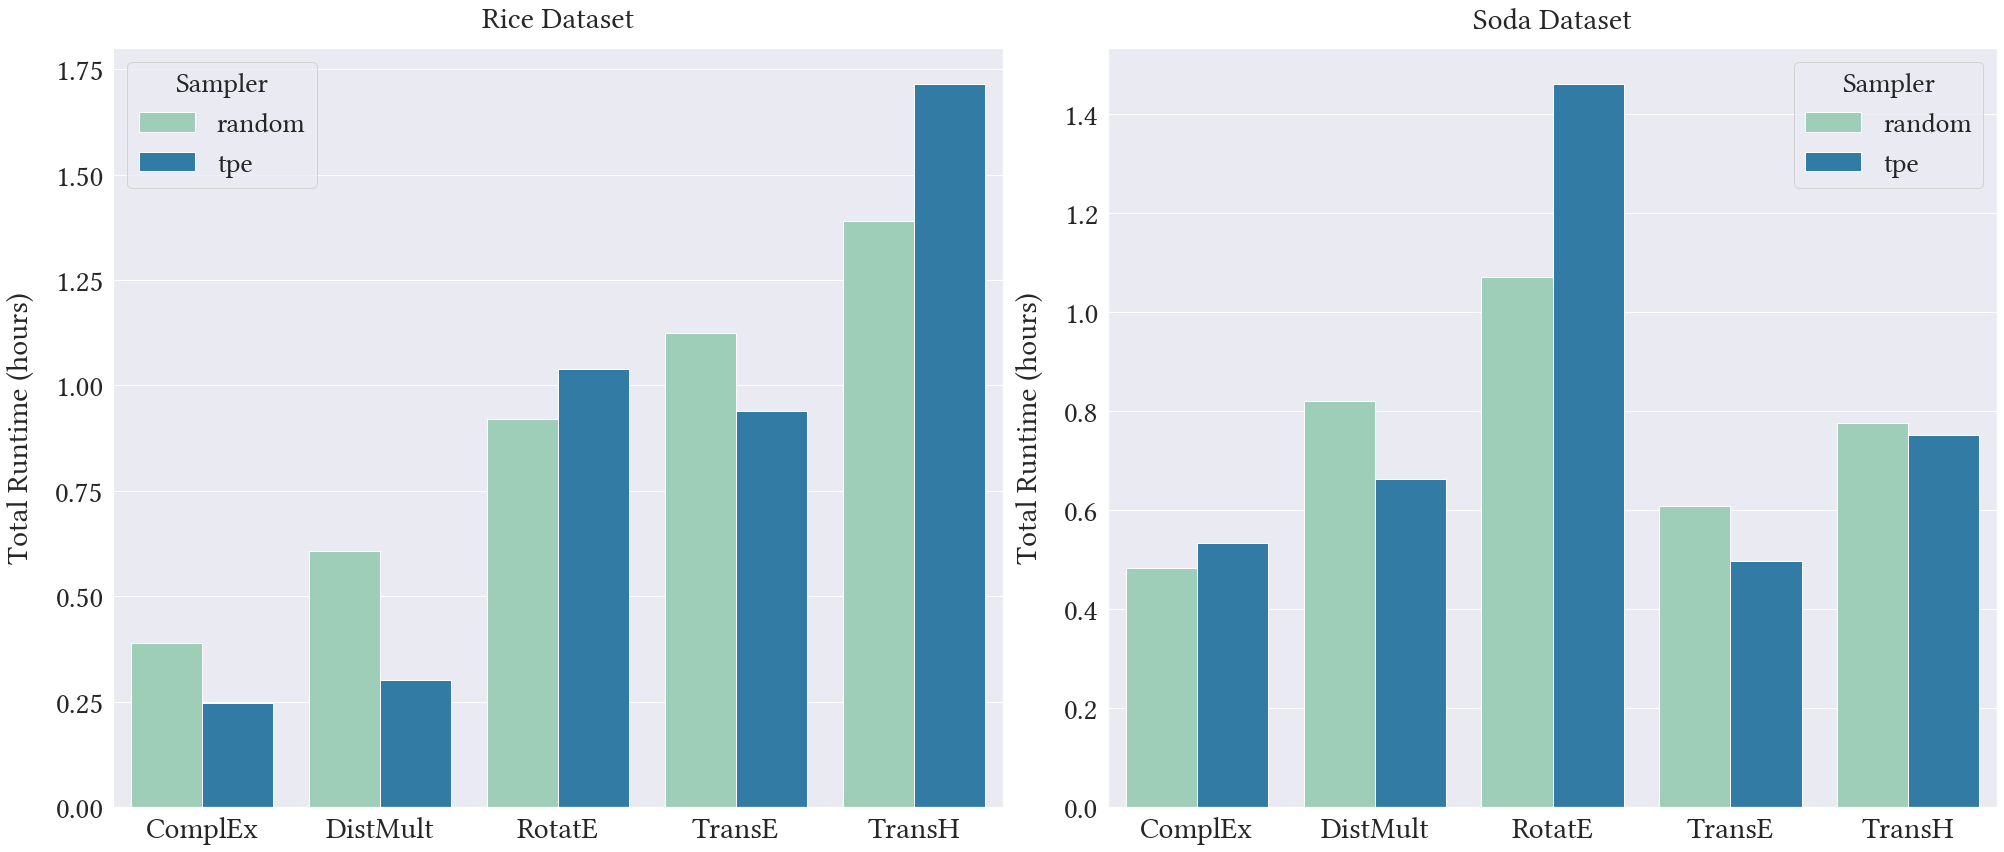

In [15]:
plt.rcParams["font.family"] = "Linux Libertine"
plt.rcParams["font.weight"] = "normal"

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(28, 12))  # 1 row, 2 columns

sns.set(style="darkgrid")

# Plot the first graph
sns.barplot(x='model', y='mean_hpo_runtime_hours', hue='sampler', data=hpo_summary_rice, palette="YlGnBu", ax=axes[0], order=model_order)
axes[0].set_title('Rice Dataset', fontsize=30, pad=20,)
axes[0].set_xlabel('')
axes[0].set_ylabel('Total Runtime (hours)', fontsize=30, labelpad=20)
axes[0].legend(title='Sampler', title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})

# Plot the second graph
sns.barplot(x='model', y='mean_hpo_runtime_hours', hue='sampler', data=hpo_summary_soda, palette="YlGnBu", ax=axes[1], order=model_order)
axes[1].set_title('Soda Dataset', fontsize=30, pad=20, )
axes[1].set_xlabel('')
axes[1].set_ylabel('Total Runtime (hours)', fontsize=30, labelpad=20)
axes[1].legend(title='Sampler' , title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})

# Adjust font size of grid markers
axes[0].tick_params(axis='both', which='major', labelsize=30)
axes[1].tick_params(axis='both', which='major', labelsize=30)

# Create the plots folder if it doesn't exist
if not os.path.exists('./plots'):
    os.makedirs('./plots')

plt.savefig('./plots/hpo_total_runtime.eps', format='eps', bbox_inches='tight')
plt.tight_layout()
plt.show()


Plot: Best HPO trial number for all models (Fig 4.4b of the thesis)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


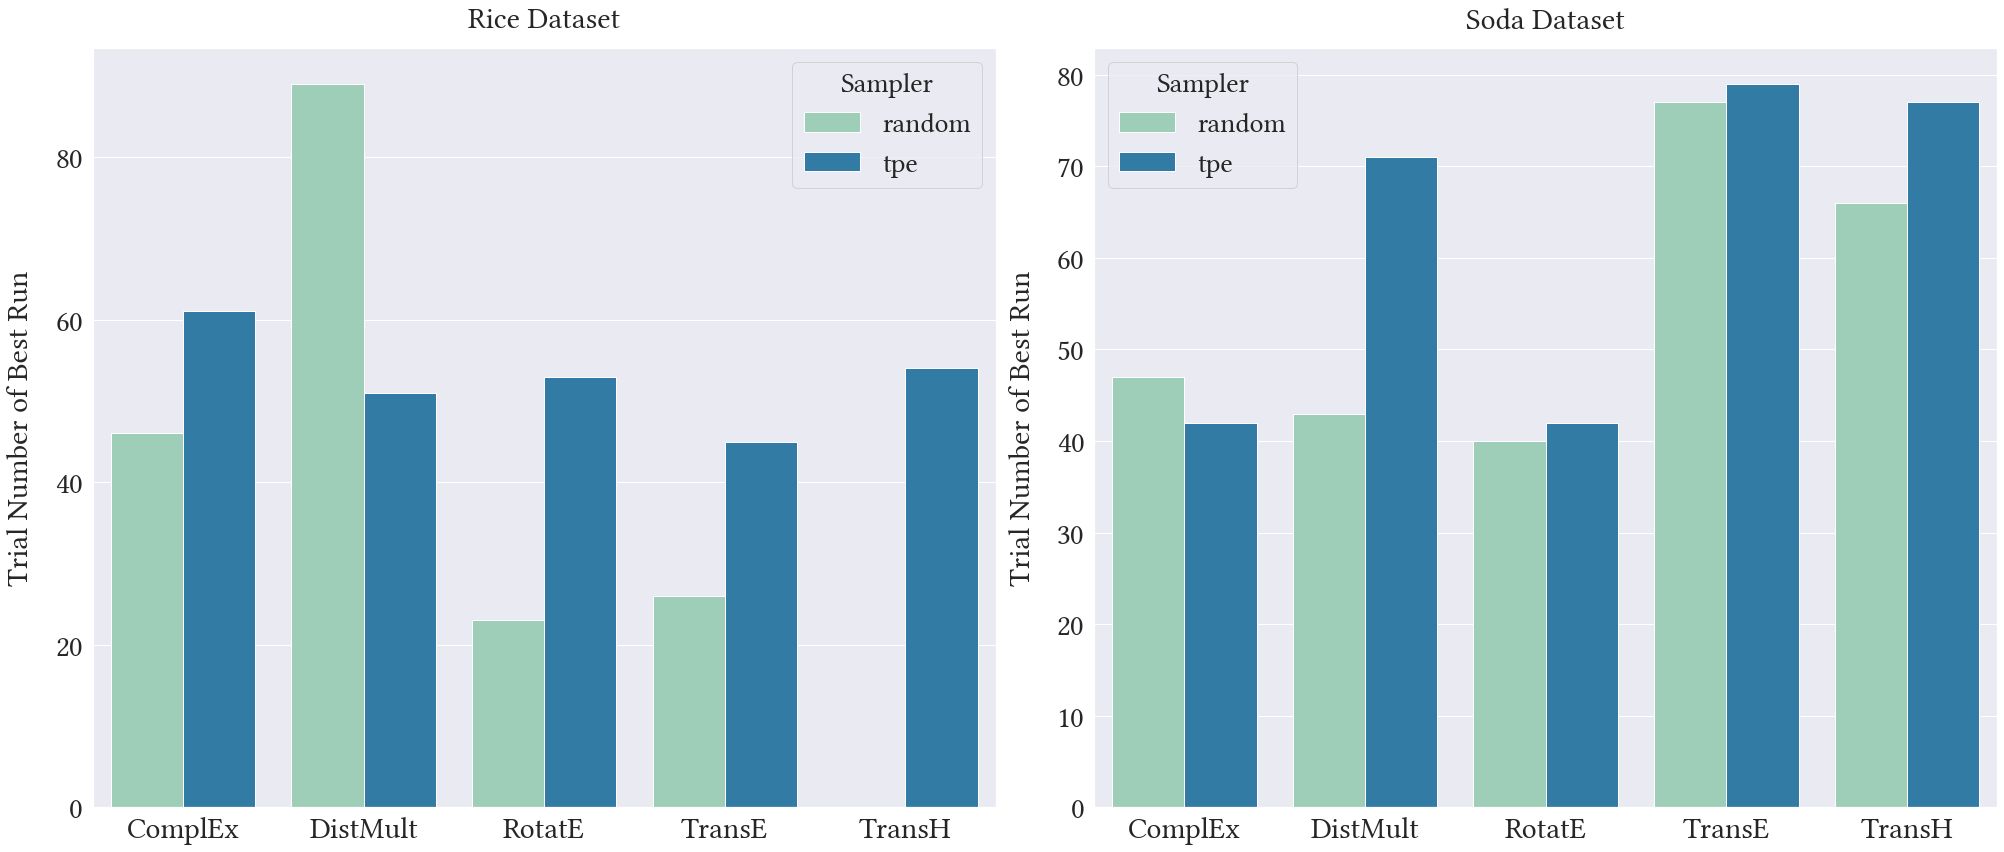

In [16]:
# Create a figure with two subplots
plt.rcParams["font.family"] = "Linux Libertine"
plt.rcParams["font.weight"] = "normal"

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(28, 12))  # 1 row, 2 columns

sns.set(style="darkgrid")

# Plot the first graph
sns.barplot(x='model', y='best_trial_number', hue='sampler', data=hpo_summary_rice, palette="YlGnBu", ax=axes[0], order=model_order)
axes[0].set_title('Rice Dataset', fontsize=30, pad=20,)
axes[0].set_xlabel('')
axes[0].set_ylabel('Trial Number of Best Run', fontsize=30, labelpad=20)
axes[0].legend(title='Sampler', title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})

# Plot the second graph
sns.barplot(x='model', y='best_trial_number', hue='sampler', data=hpo_summary_soda, palette="YlGnBu", ax=axes[1], order=model_order)
axes[1].set_title('Soda Dataset', fontsize=30, pad=20)
axes[1].set_xlabel('')
axes[1].set_ylabel('Trial Number of Best Run', fontsize=30, labelpad=20)
axes[1].legend(title='Sampler', title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})

# Adjust font size of grid markers
axes[0].tick_params(axis='both', which='major', labelsize=30)
axes[1].tick_params(axis='both', which='major', labelsize=30)

# Create the plots folder if it doesn't exist
if not os.path.exists('./plots'):
    os.makedirs('./plots')

plt.savefig('./plots/hpo_best_trial_number.eps', format='eps', bbox_inches='tight')
plt.tight_layout()
plt.show()


Plot: Best HPO trial AMR (Fig 4.5a of the thesis)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


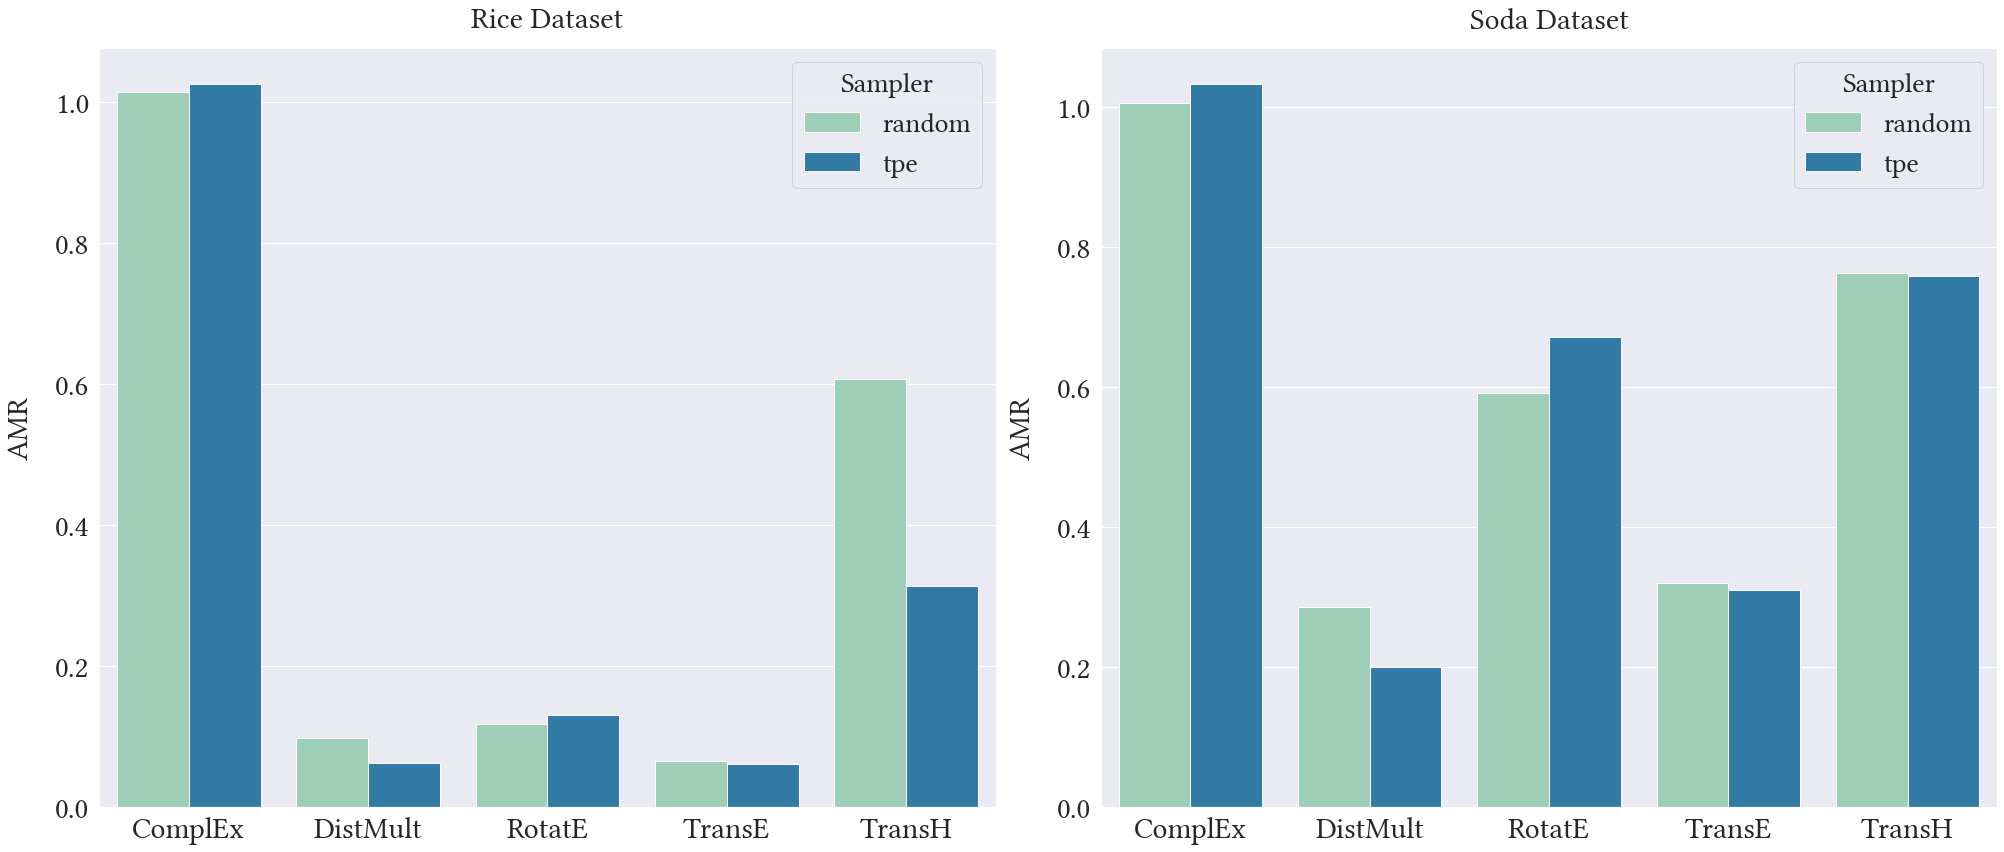

In [18]:
# Create a figure with two subplots

plt.rcParams["font.family"] = "Linux Libertine"
plt.rcParams["font.weight"] = "normal"

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(28, 12))  # 1 row, 2 columns

sns.set(style="darkgrid")

# Plot the first graph
sns.barplot(x='model', y='best_trial_AMR', hue='sampler', data=hpo_summary_rice, palette="YlGnBu", ax=axes[0], order=model_order)
axes[0].set_title('Rice Dataset', fontsize=30, pad=20,)
axes[0].set_xlabel('')
axes[0].set_ylabel('AMR', fontsize=30, labelpad=20)
axes[0].legend(title='Sampler', title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})

# Plot the second graph
sns.barplot(x='model', y='best_trial_AMR', hue='sampler', data=hpo_summary_soda, palette="YlGnBu", ax=axes[1], order=model_order)
axes[1].set_title('Soda Dataset', fontsize=30, pad=20,)
axes[1].set_xlabel('')
axes[1].set_ylabel('AMR', fontsize=30, labelpad=20)
axes[1].legend(title='Sampler', title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})

# Adjust font size of grid markers
axes[0].tick_params(axis='both', which='major', labelsize=30)
axes[1].tick_params(axis='both', which='major', labelsize=30)

# Create the plots folder if it doesn't exist
if not os.path.exists('./plots'):
    os.makedirs('./plots')

plt.savefig('./plots/hpo_best_trial_AMR.eps', format='eps', bbox_inches='tight')
plt.tight_layout()
plt.show()


Plot: Best HPO trial Hits@10 (Fig 4.5b of the thesis)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


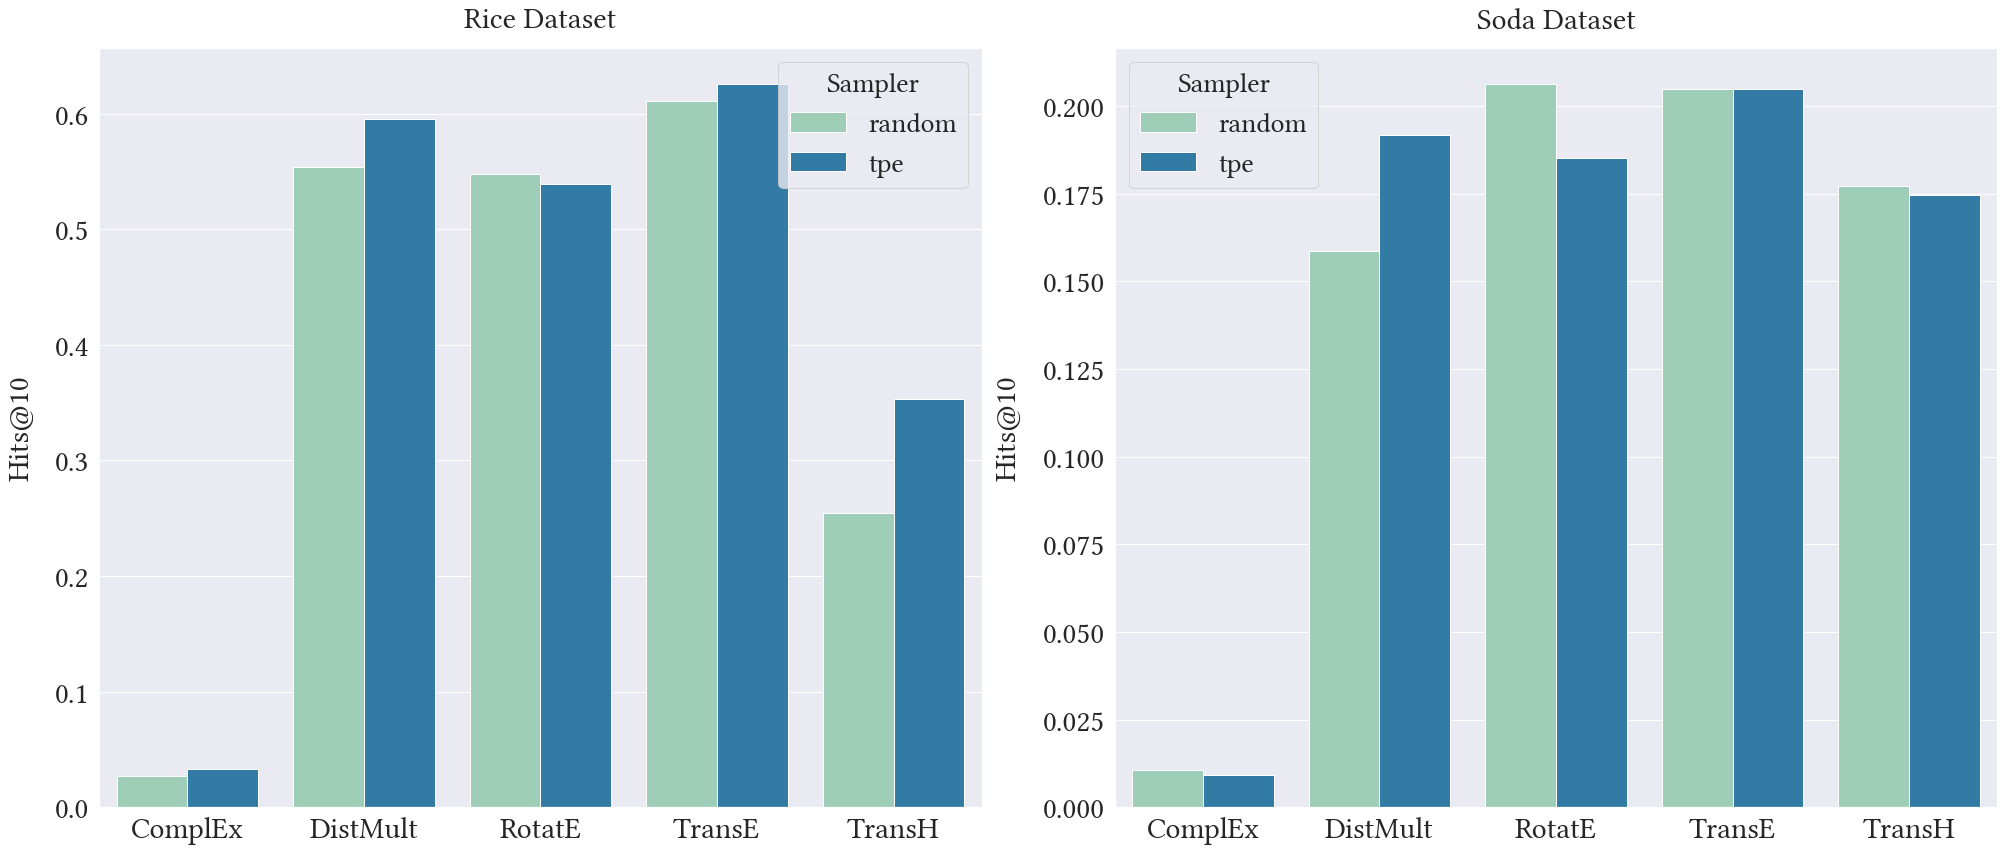

In [19]:


# Create a figure with two subplots
plt.rcParams["font.family"] = "Linux Libertine"
plt.rcParams["font.weight"] = "normal"

# Your existing code for creating subplots and plotting
fig, axes = plt.subplots(1, 2, figsize=(28, 12))

# Plot the first graph
sns.barplot(x='model', y='best_trial_hits@10', hue='sampler', data=hpo_summary_rice, palette="YlGnBu", ax=axes[0], order=model_order)
axes[0].set_title('Rice Dataset', fontsize=30, pad=20,)
axes[0].set_xlabel('')
axes[0].set_ylabel('Hits@10', fontsize=30, labelpad=20)
axes[0].legend(title='Sampler',title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})

# Plot the second graph
sns.barplot(x='model', y='best_trial_hits@10', hue='sampler', data=hpo_summary_soda, palette="YlGnBu", ax=axes[1], order=model_order)
axes[1].set_title('Soda Dataset', fontsize=30, pad=20,)
axes[1].set_xlabel('')
axes[1].set_ylabel('Hits@10', fontsize=30, labelpad=20)
axes[1].legend(title='Sampler',title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})

# Adjust font size of grid markers
axes[0].tick_params(axis='both', which='major', labelsize=30)
axes[1].tick_params(axis='both', which='major', labelsize=30)

# Create the plots folder if it doesn't exist
if not os.path.exists('./plots'):
    os.makedirs('./plots')

plt.savefig('./plots/hpo_best_trial_hits@10.eps', format='eps', bbox_inches='tight')
plt.tight_layout()
plt.show()


Plot: Distribution of Hits@10 Scores Across all HPO runs of all models (Fig 4.5c of the thesis)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


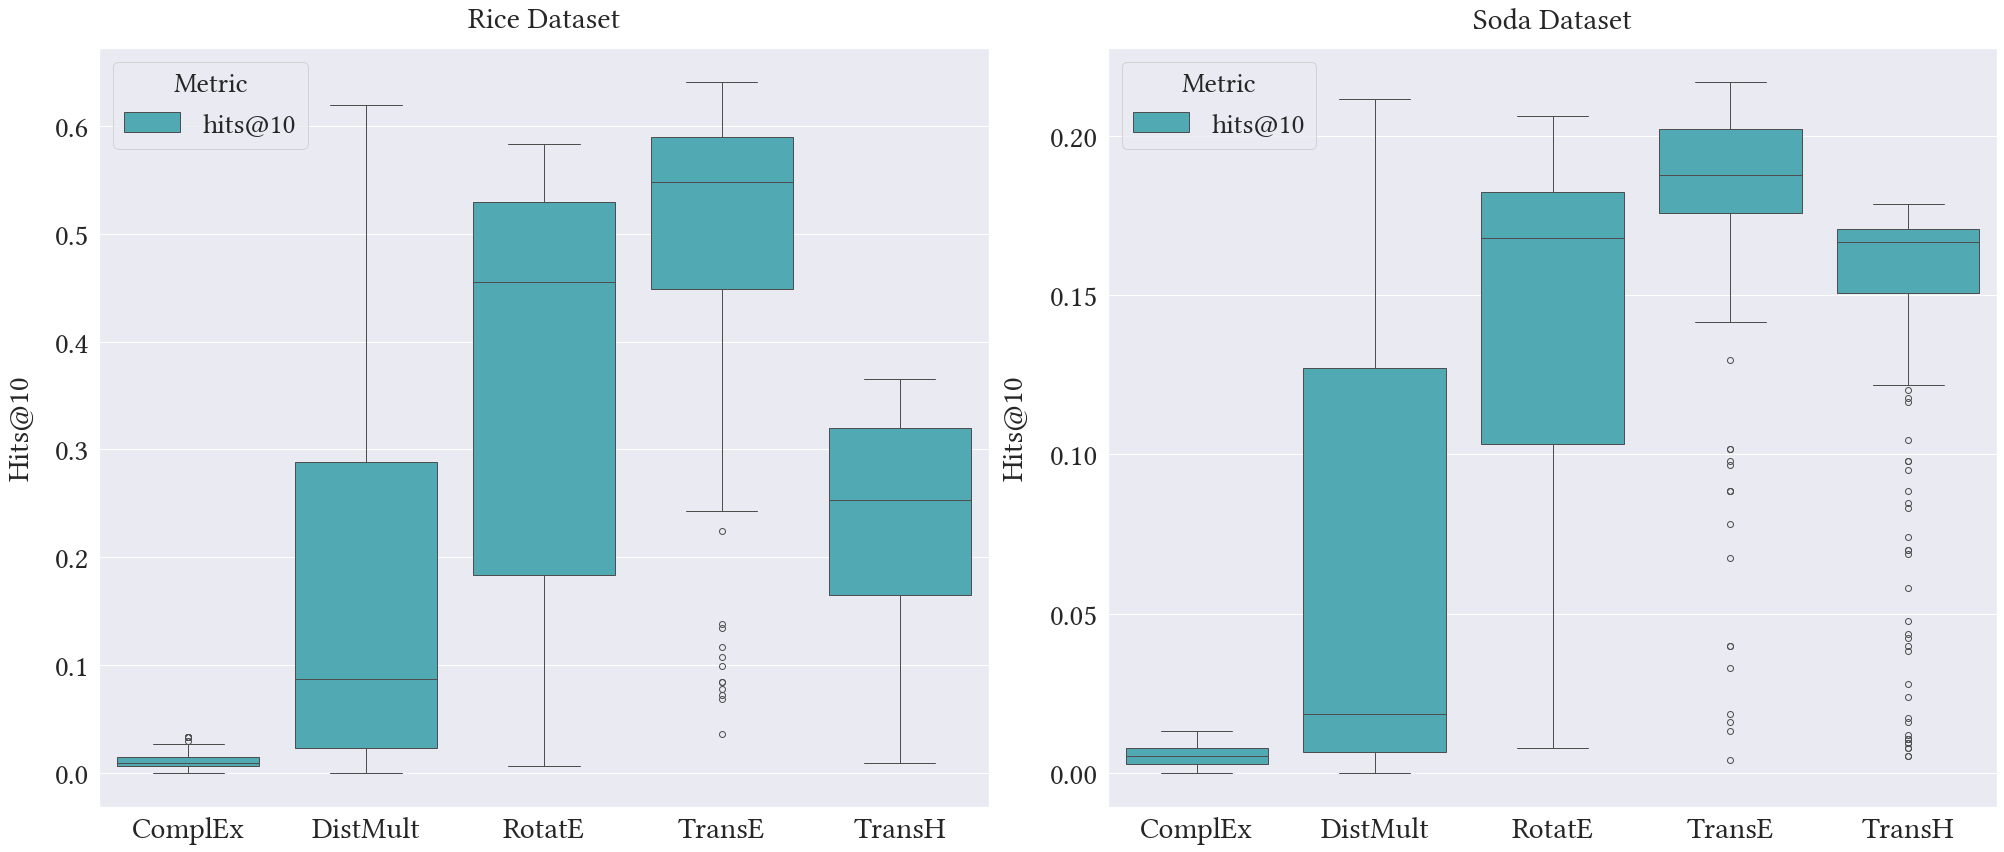

In [20]:
all_trials_hits_summary_rice_melted = all_trials_hits_summary_rice.melt(
    id_vars=['model'],  # Keep these columns as identifiers
    value_vars=['hits@1', 'hits@3', 'hits@5', 'hits@10'],  # These columns will be "melted"
    var_name='metric',  # Name of the new column that holds the name of the melted columns
    value_name='score')  # Name of the new column that holds the values of the melted columns

all_trials_hits_summary_soda_melted = all_trials_hits_summary_soda.melt(
    id_vars=['model'],  # Keep these columns as identifiers
    value_vars=['hits@1', 'hits@3', 'hits@5', 'hits@10'],  # These columns will be "melted"
    var_name='metric',  # Name of the new column that holds the name of the melted columns
    value_name='score')  # Name of the new column that holds the values of the melted columns


# Filter the data to include only Hits@10 scores
hits_10_data_rice = all_trials_hits_summary_rice_melted[all_trials_hits_summary_rice_melted['metric'] == 'hits@10']
hits_10_data_soda = all_trials_hits_summary_soda_melted[all_trials_hits_summary_soda_melted['metric'] == 'hits@10']

plt.rcParams["font.family"] = "Linux Libertine"
plt.rcParams["font.weight"] = "normal"

# Your existing code for creating subplots and plotting
fig, axes = plt.subplots(1, 2, figsize=(28, 12))

# Plot the first graph
sns.boxplot(x='model', y='score', hue='metric', data=hits_10_data_rice, palette="YlGnBu", ax=axes[0], order=model_order)
axes[0].set_title('Rice Dataset', fontsize=30, pad=20,)
axes[0].set_xlabel('')
axes[0].set_ylabel('Hits@10', fontsize=30, labelpad=20)
axes[0].legend(title='Metric', title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})

# Plot the second graph
sns.boxplot(x='model', y='score', hue='metric', data=hits_10_data_soda, palette="YlGnBu", ax=axes[1], order=model_order)
axes[1].set_title('Soda Dataset', fontsize=30, pad=20,)
axes[1].set_xlabel('')
axes[1].set_ylabel('Hits@10', fontsize=30, labelpad=20)
axes[1].legend(title='Metric', title_fontproperties={'family':"Linux Libertine", 'size':28}, prop={'family':"Linux Libertine", 'size':28})

# Adjust font size of grid markers
axes[0].tick_params(axis='both', which='major', labelsize=30)
axes[1].tick_params(axis='both', which='major', labelsize=30)

# Create the plots folder if it doesn't exist
if not os.path.exists('./plots'):
    os.makedirs('./plots')
    
plt.savefig('./plots/hpo_summary_overall_hits@10.eps', format='eps', bbox_inches='tight')
plt.tight_layout()
plt.show()